In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["LD_LIBRARY_PATH"]

'/vol/cuda/11.2.1-cudnn8.1.0.77/targets/x86_64-linux/lib:/vol/cuda/11.2.1-cudnn8.1.0.77/lib64:'

In [2]:
import sys
sys.path.append("/vol/bitbucket/ad6013/Research/gp-causal")

In [3]:
from data.get_data import get_gauss_pairs_dataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import gpflow


x, y, _, _ = get_gauss_pairs_dataset("/vol/bitbucket/ad6013/Research/gp-causal/data/gauss_pairs/files")
# Get data
# X = np.random.randn(2000, 1)
# Y = (X) + X  * (np.random.randn(2000, 1))
X = y[180]
Y = x[180]
N = X.shape[0]
num_minibatch = 150

X = StandardScaler().fit_transform(X).astype(np.float64)
Y = StandardScaler().fit_transform(Y).astype(np.float64)

In [4]:
X.shape[0]

1500

In [5]:
from models.GeneralisedGPLVM import GeneralisedGPLVM
from gpflow.config import default_float

In [6]:
from tqdm import trange
from gpflow.optimizers import NaturalGradient
import gpflow
import matplotlib.pyplot as plt


# tf.config.run_functions_eagerly(
#     True
# )

def run_optimizer(model, train_dataset, iterations, minibatch_size):
    """
    Utility function running the Adam optimizer
    Modified from https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html
    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    # gpflow.set_trainable(model.X_data_mean, False)
    # gpflow.set_trainable(model.X_data_var, False)
    # variational_params = [(model.q_mu, model.q_sqrt)]
    # natgrad_opt = NaturalGradient(gamma=0.5)
    optimizer = tf.optimizers.Adam(0.05)
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        # natgrad_opt.minimize(training_loss, variational_params)
    iterator = trange(iterations, leave=True) 
    for step in iterator:
        optimization_step()
        # logf.append(neg_elbo)
        if step % 4999 == 0:
            neg_elbo = training_loss().numpy()
            iterator.set_description(f"EPOCH: {step}, NEG ELBO: {neg_elbo}")

            # plt.plot(np.arange(len(logf)), logf)
            # plt.show()
            # plt.close()

            obs_new = np.linspace(-5, 5, 3000)[:, None]

            lower, median, upper, samples = model.predict_credible_layer(
                Xnew=obs_new,
                obs_noise=True,
            )
            plt.scatter(X[:, 0], Y[:, 0], c='r')
            plt.plot(obs_new, median, c='b', alpha=0.2)
            # plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
            plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
            plt.show()
            plt.close()

            obs_new = np.linspace(-5, 5, 1000)[:, None]
            latent_new = np.random.randn(1000, 1)
            full_new =  np.concatenate([obs_new, latent_new], axis=1)
            # full_new =  np.concatenate([obs_new, obs_new], axis=1)
            # full_new = obs_new
            pred_y_mean, pred_y_var = model.predict_y(
                full_new, full_cov=False, full_output_cov=False 
            )
            plt.scatter(X[:, 0], Y[:, 0], c='r')
            plt.plot(obs_new, pred_y_mean, c='b', alpha=0.2)
            # plt.scatter(inducing_in, np.zeros(100) )
            plt.fill_between(obs_new[:, 0], (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0], (pred_y_mean - 2 * np.sqrt(pred_y_var))[:,0], alpha=0.5)
            plt.show()
            plt.close()


            # if np.abs(np.mean(logf[-5000:])) - np.abs(np.mean(logf[-100:])) < 0.25 * np.std(logf[-100:]):
            #     print("\n BREAKING! \n")
            #     break
            
    return logf

In [7]:
M = 200  # Number of inducing locations

kernel_1 = gpflow.kernels.SquaredExponential(
    lengthscales=[0.1, 0.001]
)
kernel_1.variance.assign(1.0)
kernel_2 = gpflow.kernels.Linear(variance=1.0)
kernel = gpflow.kernels.Sum([kernel_1, kernel_2])
Z = np.concatenate(
        [
            np.linspace(X.min(), X.max(), M).reshape(-1, 1),
            # np.linspace(X.min(), X.max(), M).reshape(-1, 1),
            np.random.randn(M, 1),
        ],
        axis=1
    )
# Z = np.linspace(X.min(), X.max(), M).reshape(-1, 1) 
X_mean_init = 0.01 * tf.cast(Y, default_float())
X_var_init = tf.cast(
    np.random.uniform(0, 0.1, (X.shape[0], 1)), default_float()
)


model = GeneralisedGPLVM(
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    kernel=kernel,
    likelihood=gpflow.likelihoods.Gaussian(variance=1e-5),
    num_mc_samples=10,
    inducing_variable=Z,
    batch_size=num_minibatch,
)

2022-10-04 10:56:34.040840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 10:56:34.191293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 10:56:34.191529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-04 10:56:34.226140: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

  0%|          | 0/50000 [00:00<?, ?it/s]2022-10-04 10:57:04.404964: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-10-04 10:57:10.973142: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x78b1310
EPOCH: 0, NEG ELBO: 171216099.88253903:   0%|          | 0/50000 [00:09<?, ?it/s]

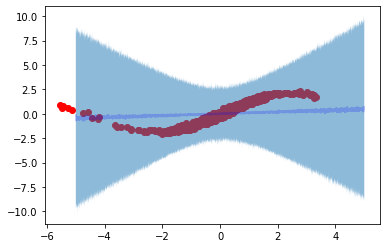

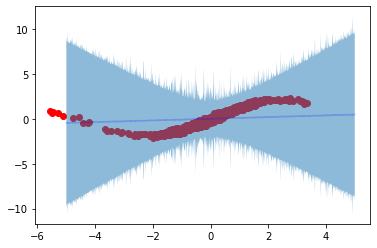

EPOCH: 0, NEG ELBO: 171216099.88253903:   5%|▌         | 2613/50000 [00:30<09:11, 85.91it/s] 


KeyboardInterrupt: 

In [8]:
data_idx = np.arange(X.shape[0])
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y, data_idx)).repeat().shuffle(X.shape[0])
logf = run_optimizer(
    model=model,
    train_dataset=train_dataset,
    iterations=50000,
    minibatch_size=num_minibatch
)
print(f"Loss is {- model.elbo((X, Y, data_idx))}")

In [9]:
print(f"Loss is {- model.elbo((X, Y, data_idx))}")

Loss is -2037.5286527203295


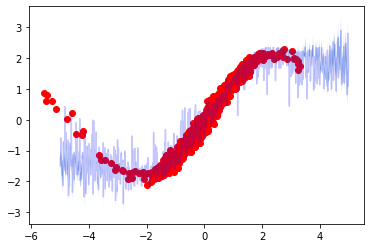

In [10]:
obs_new = np.linspace(-5, 5, 1000)[:, None]
latent_new = np.random.randn(1000, 1)
full_new =  np.concatenate([obs_new, latent_new], axis=1)
# full_new =  np.concatenate([obs_new, obs_new], axis=1)
# full_new = obs_new
pred_y_mean, pred_y_var = model.predict_y(
    full_new, full_cov=False, full_output_cov=False 
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, pred_y_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0], (pred_y_mean - 2 * np.sqrt(pred_y_var))[:,0], alpha=0.5)
plt.show()
plt.close()

In [11]:
import gpflow
from gpflow.utilities import print_summary

print_summary(model)

╒═════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════════╤═════════╤══════════════════════════════════════════════════════╕
│ name                                            │ class     │ transform        │ prior   │ trainable   │ shape         │ dtype   │ value                                                │
╞═════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════════╪═════════╪══════════════════════════════════════════════════════╡
│ GeneralisedGPLVM.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()            │ float64 │ 0.27394960196236406                                  │
├─────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────────┼─────────┼──────────────────────────────────────────────────────┤
│ GeneralisedGPLVM.kernel.kernels[0].lengthscales │ Paramete

In [14]:
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM

X_mean_init = model.X_data_mean.numpy()
X_var_init = model.X_data_var.numpy()

Z = model.inducing_variable

kernel = model.kernel

likelihood = model.likelihood

model_bayes = PartObsBayesianGPLVM(
    data=Y,
    in_data=X,
    kernel=kernel,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    inducing_variable=Z,
    jitter=1e-6,
)

In [15]:
import gpflow

gpflow.utilities.set_trainable(model_bayes.kernel, True)
gpflow.utilities.set_trainable(model_bayes.likelihood, True)
gpflow.utilities.set_trainable(model_bayes.X_data_mean , True)
gpflow.utilities.set_trainable(model_bayes.X_data_var, True)
gpflow.utilities.set_trainable(model_bayes.inducing_variable, True)
opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(
    model_bayes.training_loss,
    model_bayes.trainable_variables,
    options=dict(maxiter=200000),
)

In [16]:
- model_bayes.elbo()

<tf.Tensor: shape=(), dtype=float64, numpy=-668.6265116496915>

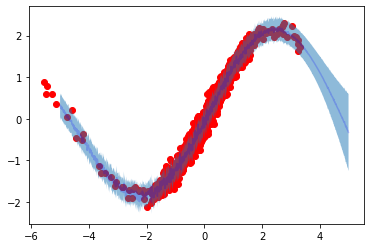

In [17]:
obs_new = np.linspace(-5, 5, 1000)[:, None]
latent_new = np.random.randn(1000, 1)
full_new =  np.concatenate([obs_new, latent_new], axis=1)
pred_y_mean, pred_y_var = model_bayes.predict_y(
    full_new, full_cov=False, full_output_cov=False 
)
plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, pred_y_mean, c='b', alpha=0.2)
# plt.scatter(inducing_in, np.zeros(100) )
plt.fill_between(obs_new[:, 0], (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0], (pred_y_mean - 2 * np.sqrt(pred_y_var))[:,0], alpha=0.5)
plt.show()
plt.close()

In [ ]:
import matplotlib.pyplot as plt

obs_new = np.linspace(-5, 5, 1000)[:, None]
latent_new = np.random.randn(1000, 1)
full_new =  np.concatenate([obs_new, latent_new], axis=1)

In [ ]:
lower, median, upper, samples = model.predict_credible_layer(obs_new, obs_noise=True)

plt.scatter(X[:, 0], Y[:, 0], c='r')
plt.plot(obs_new, median, c='b', alpha=0.2)
# plt.scatter(obs_new[:, 0], samples[0, 0], alpha=0.5)
plt.fill_between(obs_new[:, 0], upper[:, 0], lower[:, 0], alpha=0.5)
plt.show()
plt.close()

In [ ]:
data_idx = np.arange(X.shape[0])
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y, data_idx)).repeat()
ds_iter = iter(train_dataset.batch(1500))

In [6]:
from models.PartObsBayesianGPLVM import PartObsBayesianGPLVM
from gpflow.base import Parameter
from gpflow.utilities import positive


M = 200  # Number of inducing locations

kernel_1 = gpflow.kernels.SquaredExponential(
    lengthscales=[0.1, 0.011]
)
kernel_1.variance.assign(1.0)
kernel_2 = gpflow.kernels.Linear(variance=1.0)
kernel = gpflow.kernels.Sum([kernel_1, kernel_2])
Z = np.concatenate(
        [
            np.linspace(X.min(), X.max(), M).reshape(-1, 1),
            np.random.randn(M, 1),
        ],
        axis=1
    )
X_mean_init = 0.01 * tf.cast(Y, default_float())
X_var_init = tf.cast(
    np.random.uniform(0, 0.1, (X.shape[0], 1)), default_float()
)

model_bayes = PartObsBayesianGPLVM(
    data=Y,
    in_data=X,
    kernel=kernel,
    X_data_mean=X_mean_init,
    X_data_var=X_var_init,
    inducing_variable=Z,
    jitter=1e-6,
)
model_bayes.likelihood.variance = Parameter(
    1e-5, transform=positive(lower=1e-6)
)

loss_fn = model_bayes.training_loss_closure()

adam_vars = model_bayes.trainable_variables
adam_opt = tf.optimizers.Adam(0.005)
@tf.function
def optimisation_step():
    adam_opt.minimize(loss_fn, adam_vars)

2022-09-27 14:48:31.351431: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 14:48:31.360949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 14:48:31.361074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-27 14:48:31.361519: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

  1%|          | 499/50000 [01:08<1:53:29,  7.27it/s]

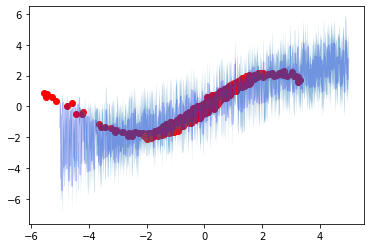

  1%|          | 502/50000 [01:09<3:12:55,  4.28it/s]

NEG ELBO: 310233.0381407977


  2%|▏         | 999/50000 [02:17<1:52:20,  7.27it/s]

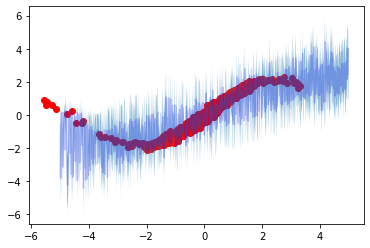

  2%|▏         | 1002/50000 [02:18<2:18:01,  5.92it/s]

NEG ELBO: 169810.39917001684


  3%|▎         | 1499/50000 [03:26<1:51:05,  7.28it/s]

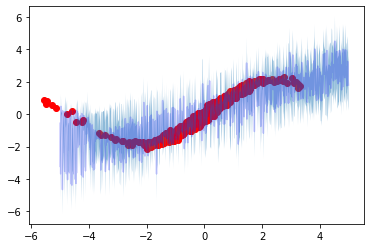

  3%|▎         | 1502/50000 [03:27<2:13:34,  6.05it/s]

NEG ELBO: 108198.20052596593


  4%|▍         | 1999/50000 [04:35<1:50:02,  7.27it/s]

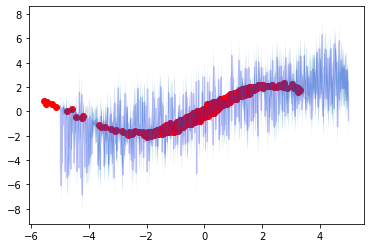

  4%|▍         | 2002/50000 [04:36<2:15:36,  5.90it/s]

NEG ELBO: 64132.04419884212


  5%|▍         | 2499/50000 [05:44<1:48:48,  7.28it/s]

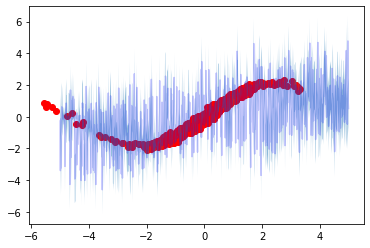

  5%|▌         | 2502/50000 [05:45<2:11:09,  6.04it/s]

NEG ELBO: 43726.232228009096


  6%|▌         | 2999/50000 [06:53<1:47:44,  7.27it/s]

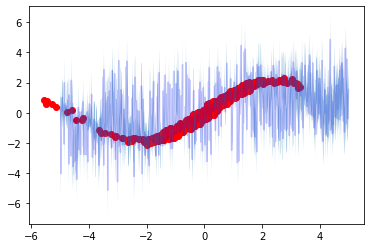

  6%|▌         | 3002/50000 [06:54<2:09:45,  6.04it/s]

NEG ELBO: 31245.028825245725


  7%|▋         | 3499/50000 [08:02<1:46:28,  7.28it/s]

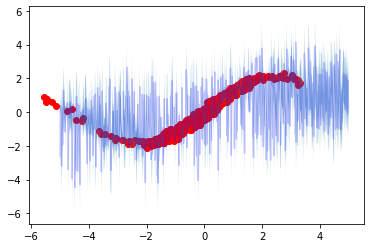

  7%|▋         | 3502/50000 [08:02<2:08:46,  6.02it/s]

NEG ELBO: 23007.70338650818


  8%|▊         | 3999/50000 [09:11<1:45:16,  7.28it/s]

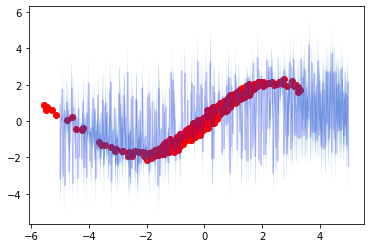

  8%|▊         | 4002/50000 [09:11<2:06:51,  6.04it/s]

NEG ELBO: 17378.997521095924


  9%|▉         | 4499/50000 [10:20<1:43:56,  7.30it/s]

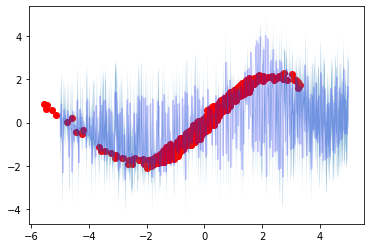

  9%|▉         | 4502/50000 [10:20<2:05:29,  6.04it/s]

NEG ELBO: 13100.217279364046


 10%|▉         | 4999/50000 [11:29<1:42:47,  7.30it/s]

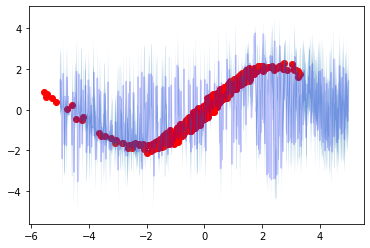

 10%|█         | 5002/50000 [11:29<2:04:37,  6.02it/s]

NEG ELBO: 10042.094828396559


 11%|█         | 5499/50000 [12:37<1:41:40,  7.29it/s]

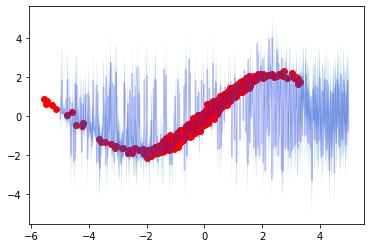

 11%|█         | 5502/50000 [12:38<2:02:15,  6.07it/s]

NEG ELBO: 7769.018641030454


 12%|█▏        | 5999/50000 [13:46<1:40:50,  7.27it/s]

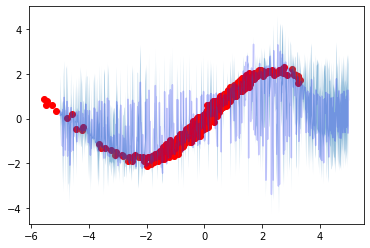

 12%|█▏        | 6002/50000 [13:47<2:03:06,  5.96it/s]

NEG ELBO: 5682.249312876748


 13%|█▎        | 6499/50000 [14:55<1:39:28,  7.29it/s]

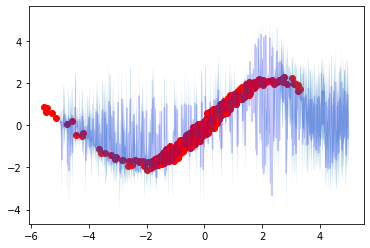

 13%|█▎        | 6502/50000 [14:56<2:01:01,  5.99it/s]

NEG ELBO: 4444.567402929122


 14%|█▍        | 6999/50000 [16:04<1:38:37,  7.27it/s]

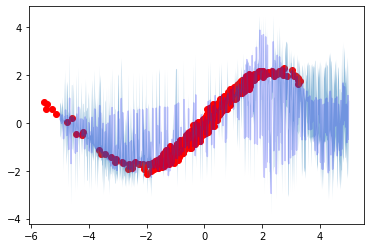

 14%|█▍        | 7002/50000 [16:05<1:58:24,  6.05it/s]

NEG ELBO: 3438.756636839593


 15%|█▍        | 7499/50000 [17:13<1:37:20,  7.28it/s]

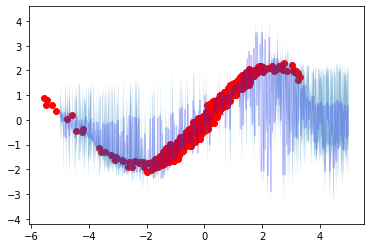

 15%|█▌        | 7502/50000 [17:14<1:57:13,  6.04it/s]

NEG ELBO: 2712.4400664740115


 16%|█▌        | 7999/50000 [18:22<1:36:17,  7.27it/s]

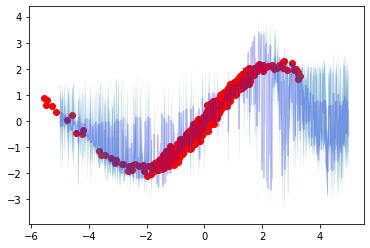

 16%|█▌        | 8002/50000 [18:23<1:56:11,  6.02it/s]

NEG ELBO: 2070.563430495704


 17%|█▋        | 8499/50000 [19:31<1:35:17,  7.26it/s]

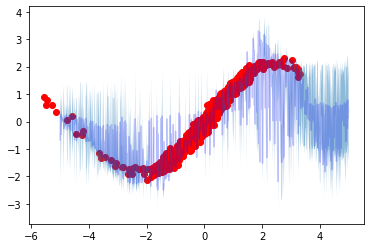

 17%|█▋        | 8502/50000 [19:31<1:54:47,  6.03it/s]

NEG ELBO: 1660.7913694214049


 18%|█▊        | 8999/50000 [20:40<1:33:49,  7.28it/s]

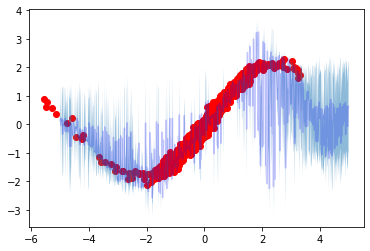

 18%|█▊        | 9002/50000 [20:40<1:53:50,  6.00it/s]

NEG ELBO: 1382.4097093588334


 19%|█▉        | 9499/50000 [21:49<1:32:36,  7.29it/s]

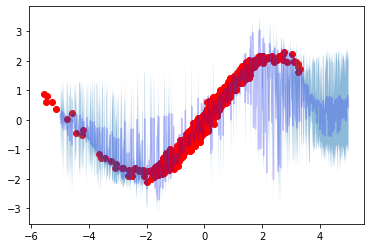

 19%|█▉        | 9502/50000 [21:49<1:51:26,  6.06it/s]

NEG ELBO: 1188.103822133594


 20%|█▉        | 9999/50000 [22:58<1:31:33,  7.28it/s]

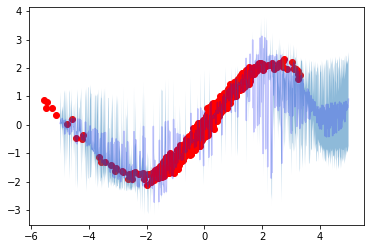

 20%|██        | 10002/50000 [22:58<1:51:06,  6.00it/s]

NEG ELBO: 1054.6922921040987


 21%|██        | 10499/50000 [24:06<1:30:26,  7.28it/s]

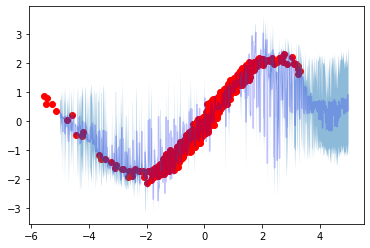

 21%|██        | 10502/50000 [24:07<1:49:22,  6.02it/s]

NEG ELBO: 954.553137913199


 22%|██▏       | 10999/50000 [25:15<1:29:04,  7.30it/s]

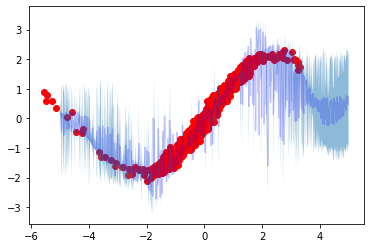

 22%|██▏       | 11002/50000 [25:16<1:47:32,  6.04it/s]

NEG ELBO: 877.8980162647085


 23%|██▎       | 11499/50000 [26:24<1:28:12,  7.27it/s]

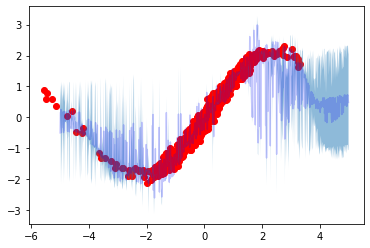

 23%|██▎       | 11502/50000 [26:25<2:02:45,  5.23it/s]

NEG ELBO: 817.7418969928312


 24%|██▍       | 11999/50000 [27:33<1:26:58,  7.28it/s]

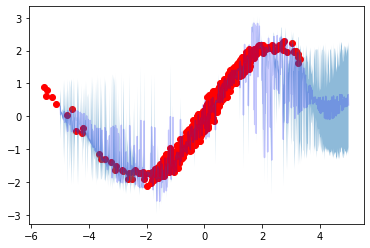

 24%|██▍       | 12002/50000 [27:34<1:44:32,  6.06it/s]

NEG ELBO: 769.8713936515369


 25%|██▍       | 12499/50000 [28:42<1:25:39,  7.30it/s]

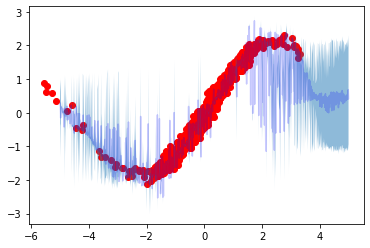

 25%|██▌       | 12502/50000 [28:43<1:43:11,  6.06it/s]

NEG ELBO: 724.3847786780188


 26%|██▌       | 12999/50000 [29:51<1:24:49,  7.27it/s]

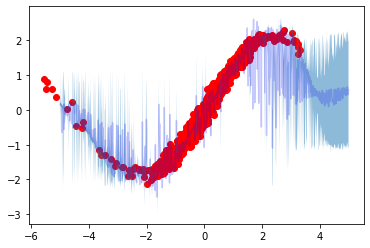

 26%|██▌       | 13002/50000 [29:52<1:41:37,  6.07it/s]

NEG ELBO: 684.2151467787526


 27%|██▋       | 13499/50000 [31:00<1:23:19,  7.30it/s]

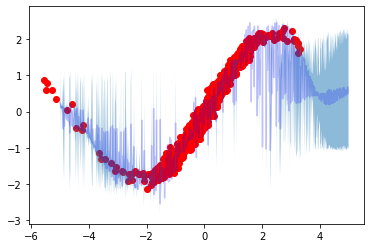

 27%|██▋       | 13502/50000 [31:01<1:40:41,  6.04it/s]

NEG ELBO: 649.2056883514533


 28%|██▊       | 13999/50000 [32:09<1:22:28,  7.28it/s]

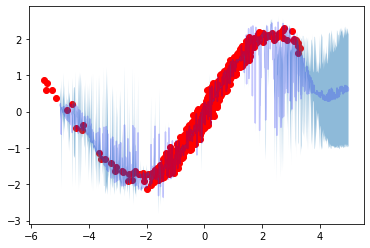

 28%|██▊       | 14002/50000 [32:10<1:38:31,  6.09it/s]

NEG ELBO: 615.7622008107446


 29%|██▉       | 14499/50000 [33:18<1:21:12,  7.29it/s]

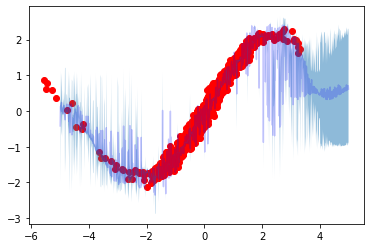

 29%|██▉       | 14502/50000 [33:18<1:37:38,  6.06it/s]

NEG ELBO: 579.9345015985155


 30%|██▉       | 14999/50000 [34:27<1:20:21,  7.26it/s]

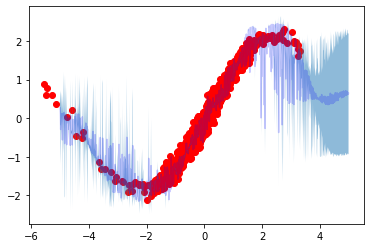

 30%|███       | 15002/50000 [34:27<1:35:42,  6.09it/s]

NEG ELBO: 554.4343818346906


 31%|███       | 15499/50000 [35:36<1:18:55,  7.29it/s]

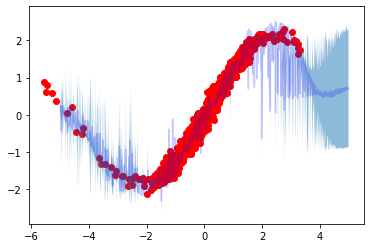

 31%|███       | 15502/50000 [35:36<1:34:40,  6.07it/s]

NEG ELBO: 531.880576071736


 32%|███▏      | 15999/50000 [36:45<1:17:47,  7.29it/s]

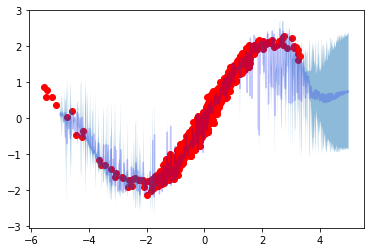

 32%|███▏      | 16002/50000 [36:45<1:33:22,  6.07it/s]

NEG ELBO: 513.6896210473642


 33%|███▎      | 16499/50000 [37:53<1:16:41,  7.28it/s]

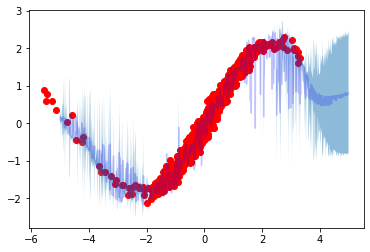

 33%|███▎      | 16502/50000 [37:54<1:31:43,  6.09it/s]

NEG ELBO: 497.8418264974962


 34%|███▍      | 16999/50000 [39:02<1:15:31,  7.28it/s]

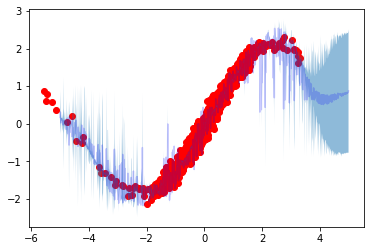

 34%|███▍      | 17002/50000 [39:03<1:30:22,  6.08it/s]

NEG ELBO: 473.19385148077436


 35%|███▍      | 17499/50000 [40:11<1:14:28,  7.27it/s]

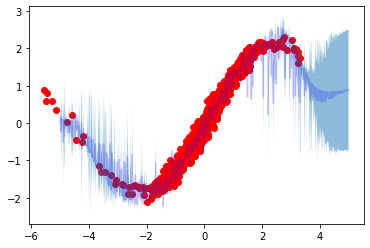

 35%|███▌      | 17502/50000 [40:12<1:29:31,  6.05it/s]

NEG ELBO: 454.8289753207846


 36%|███▌      | 17999/50000 [41:20<1:13:04,  7.30it/s]

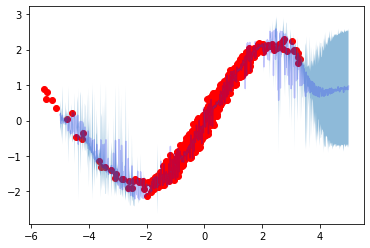

 36%|███▌      | 18002/50000 [41:21<1:27:39,  6.08it/s]

NEG ELBO: 424.25544693419397


 37%|███▋      | 18499/50000 [42:29<1:12:12,  7.27it/s]

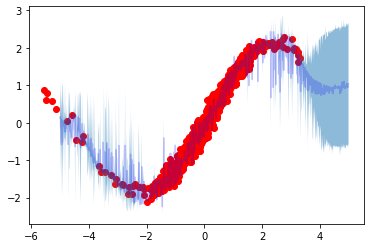

 37%|███▋      | 18502/50000 [42:30<1:25:46,  6.12it/s]

NEG ELBO: 380.0208438198315


 38%|███▊      | 18999/50000 [43:38<1:11:02,  7.27it/s]

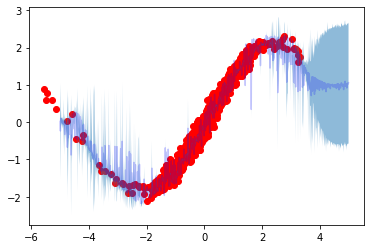

 38%|███▊      | 19002/50000 [43:39<1:25:16,  6.06it/s]

NEG ELBO: 344.12980175353823


 39%|███▉      | 19499/50000 [44:47<1:09:51,  7.28it/s]

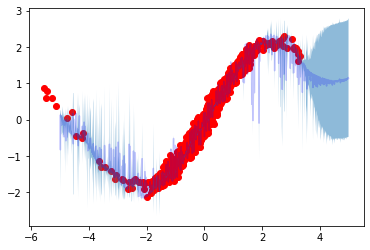

 39%|███▉      | 19502/50000 [44:47<1:23:21,  6.10it/s]

NEG ELBO: 293.6991016760212


 40%|███▉      | 19999/50000 [45:56<1:08:44,  7.27it/s]

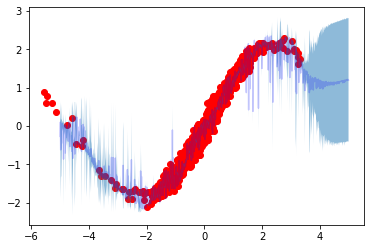

 40%|████      | 20002/50000 [45:56<1:22:15,  6.08it/s]

NEG ELBO: 245.88615990470407


 41%|████      | 20499/50000 [47:05<1:07:31,  7.28it/s]

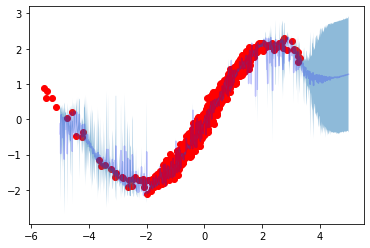

 41%|████      | 20502/50000 [47:05<1:20:52,  6.08it/s]

NEG ELBO: 173.57080595350226


 42%|████▏     | 20999/50000 [48:13<1:06:27,  7.27it/s]

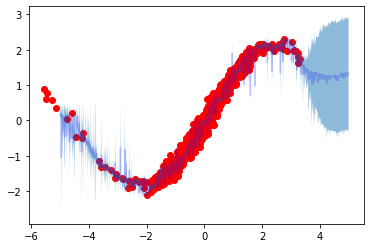

 42%|████▏     | 21002/50000 [48:14<1:19:16,  6.10it/s]

NEG ELBO: 60.93571315913323


 43%|████▎     | 21499/50000 [49:22<1:05:16,  7.28it/s]

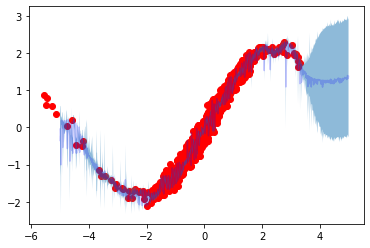

 43%|████▎     | 21502/50000 [49:23<1:17:58,  6.09it/s]

NEG ELBO: -113.86404275633276


 44%|████▍     | 21999/50000 [50:31<1:04:03,  7.29it/s]

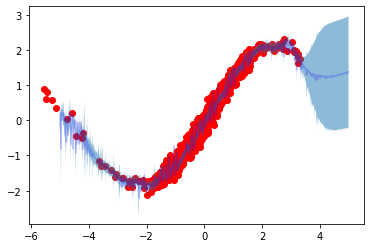

 44%|████▍     | 22002/50000 [50:32<1:16:45,  6.08it/s]

NEG ELBO: -363.3517691910247


 45%|████▍     | 22499/50000 [51:40<1:03:02,  7.27it/s]

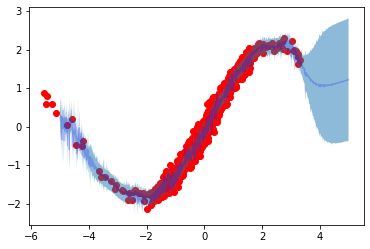

 45%|████▌     | 22502/50000 [51:41<1:14:50,  6.12it/s]

NEG ELBO: -542.1087845879156


 46%|████▌     | 22999/50000 [52:49<1:01:41,  7.29it/s]

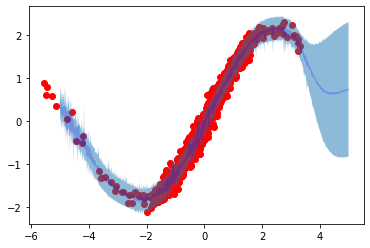

 46%|████▌     | 23002/50000 [52:50<1:13:39,  6.11it/s]

NEG ELBO: -605.8708593008967


 47%|████▋     | 23499/50000 [53:58<1:00:43,  7.27it/s]

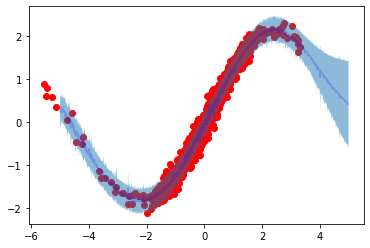

 47%|████▋     | 23502/50000 [53:59<1:12:14,  6.11it/s]

NEG ELBO: -647.6541881357779


 48%|████▊     | 23999/50000 [55:07<59:39,  7.26it/s]  

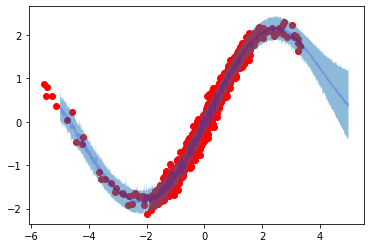

 48%|████▊     | 24002/50000 [55:07<1:11:18,  6.08it/s]

NEG ELBO: -656.1061324003755


 49%|████▉     | 24499/50000 [56:16<58:28,  7.27it/s]  

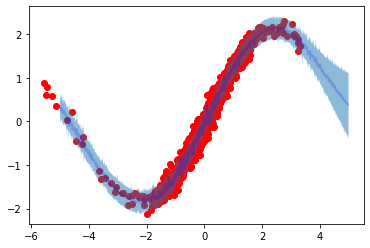

 49%|████▉     | 24502/50000 [56:16<1:09:47,  6.09it/s]

NEG ELBO: -659.2505539558556


 50%|████▉     | 24999/50000 [57:25<57:03,  7.30it/s]  

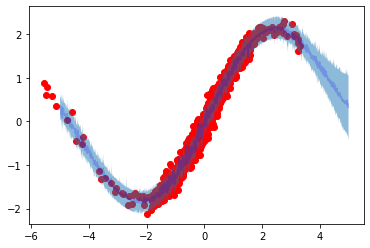

 50%|█████     | 25002/50000 [57:25<1:08:19,  6.10it/s]

NEG ELBO: -661.5647793422264


 51%|█████     | 25499/50000 [58:34<55:58,  7.29it/s]  

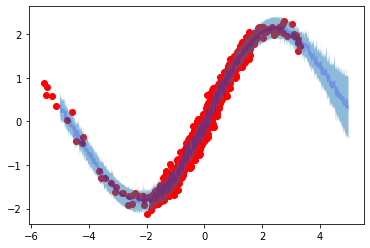

 51%|█████     | 25502/50000 [58:34<1:07:11,  6.08it/s]

NEG ELBO: -663.469440677097


 52%|█████▏    | 25999/50000 [59:42<55:06,  7.26it/s]  

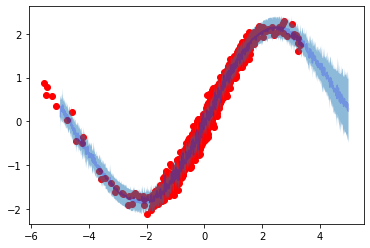

 52%|█████▏    | 26002/50000 [59:43<1:05:17,  6.13it/s]

NEG ELBO: -665.0906894346779


 53%|█████▎    | 26499/50000 [1:00:51<53:51,  7.27it/s]

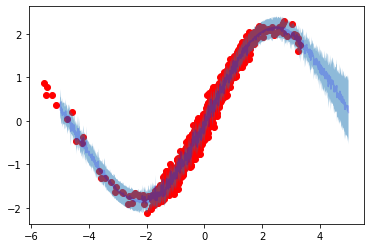

 53%|█████▎    | 26502/50000 [1:00:52<1:05:00,  6.03it/s]

NEG ELBO: -666.4868465415664


 54%|█████▍    | 26999/50000 [1:02:00<52:31,  7.30it/s]  

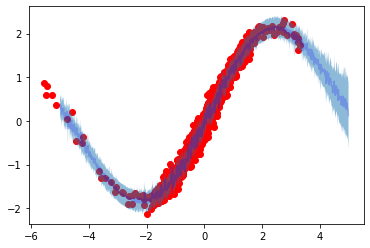

 54%|█████▍    | 27002/50000 [1:02:01<1:03:25,  6.04it/s]

NEG ELBO: -667.6891022561794


 55%|█████▍    | 27499/50000 [1:03:09<51:22,  7.30it/s]  

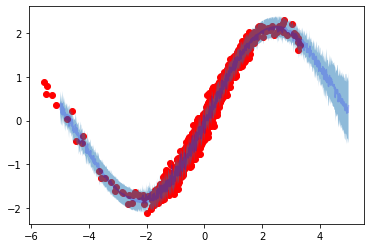

 55%|█████▌    | 27502/50000 [1:03:10<1:01:29,  6.10it/s]

NEG ELBO: -668.7174679769626


 56%|█████▌    | 27999/50000 [1:04:18<50:22,  7.28it/s]  

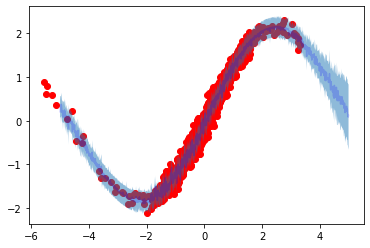

 56%|█████▌    | 28002/50000 [1:04:19<59:51,  6.12it/s]  

NEG ELBO: -669.588568542825


 57%|█████▋    | 28499/50000 [1:05:27<49:17,  7.27it/s]

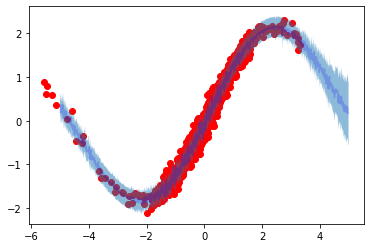

 57%|█████▋    | 28502/50000 [1:05:28<58:39,  6.11it/s]  

NEG ELBO: -670.3190040485558


 58%|█████▊    | 28999/50000 [1:06:36<48:05,  7.28it/s]

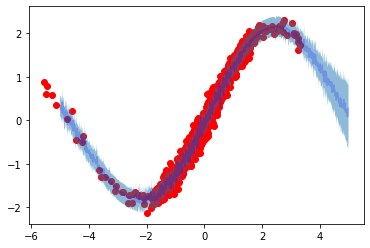

 58%|█████▊    | 29002/50000 [1:06:36<57:10,  6.12it/s]  

NEG ELBO: -670.9260118590129


 59%|█████▉    | 29499/50000 [1:07:45<47:01,  7.27it/s]

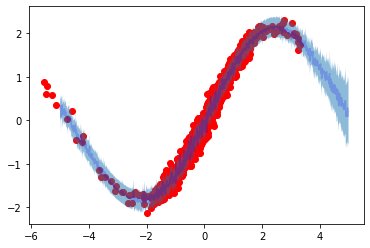

 59%|█████▉    | 29502/50000 [1:07:45<55:53,  6.11it/s]  

NEG ELBO: -671.4268912719167


 60%|█████▉    | 29999/50000 [1:08:54<45:47,  7.28it/s]

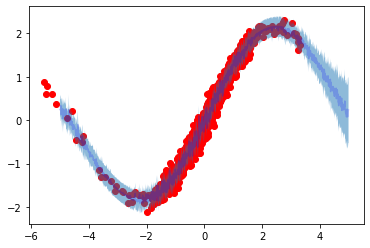

 60%|██████    | 30002/50000 [1:08:54<54:41,  6.09it/s]  

NEG ELBO: -671.8380993176473


 61%|██████    | 30499/50000 [1:10:03<44:37,  7.28it/s]

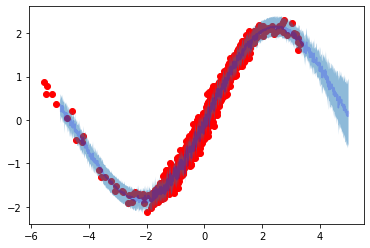

 61%|██████    | 30502/50000 [1:10:03<53:20,  6.09it/s]  

NEG ELBO: -672.1744674530077


 62%|██████▏   | 30999/50000 [1:11:11<43:30,  7.28it/s]

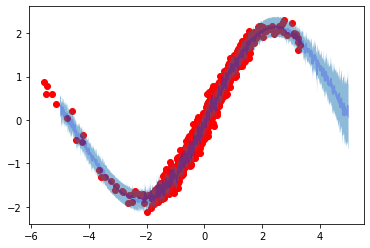

 62%|██████▏   | 31002/50000 [1:11:12<1:01:32,  5.15it/s]

NEG ELBO: -672.4484110039056


 63%|██████▎   | 31499/50000 [1:12:21<42:25,  7.27it/s]  

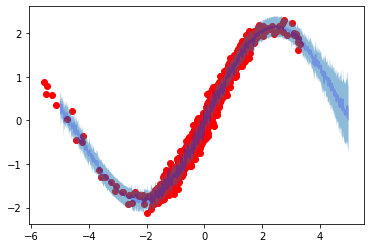

 63%|██████▎   | 31502/50000 [1:12:21<50:33,  6.10it/s]  

NEG ELBO: -672.6704845621057


 64%|██████▍   | 31999/50000 [1:13:30<41:13,  7.28it/s]

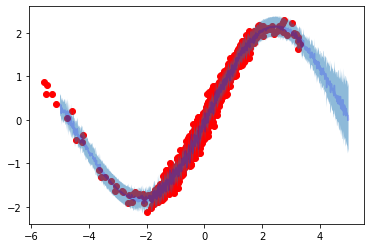

 64%|██████▍   | 32002/50000 [1:13:30<49:18,  6.08it/s]  

NEG ELBO: -672.8496069096632


 65%|██████▍   | 32499/50000 [1:14:38<40:05,  7.28it/s]

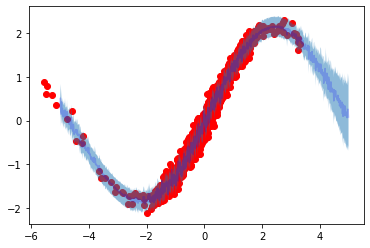

 65%|██████▌   | 32502/50000 [1:14:39<47:58,  6.08it/s]  

NEG ELBO: -672.9931256285465


 66%|██████▌   | 32999/50000 [1:15:47<38:55,  7.28it/s]

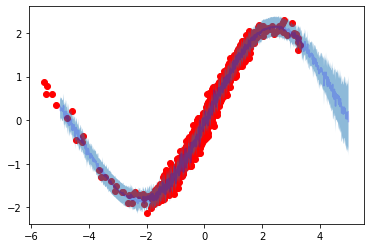

 66%|██████▌   | 33002/50000 [1:15:48<46:31,  6.09it/s]  

NEG ELBO: -673.1070319761186


 67%|██████▋   | 33499/50000 [1:16:56<37:49,  7.27it/s]

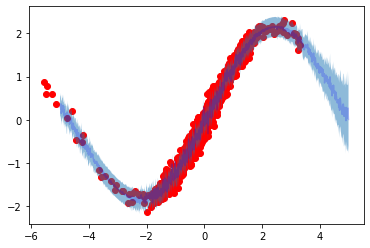

 67%|██████▋   | 33502/50000 [1:16:57<44:59,  6.11it/s]  

NEG ELBO: -673.1962420409


 68%|██████▊   | 33999/50000 [1:18:05<36:39,  7.27it/s]

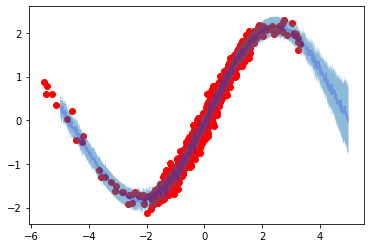

 68%|██████▊   | 34002/50000 [1:18:06<44:31,  5.99it/s]  

NEG ELBO: -673.2643922228433


 69%|██████▉   | 34499/50000 [1:19:14<35:24,  7.30it/s]

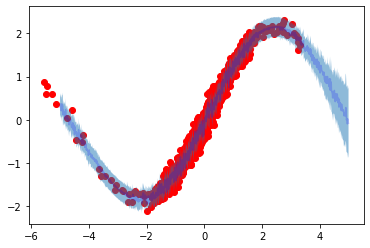

 69%|██████▉   | 34502/50000 [1:19:15<42:27,  6.08it/s]

NEG ELBO: -673.3156329829947


 70%|██████▉   | 34999/50000 [1:20:23<34:22,  7.27it/s]

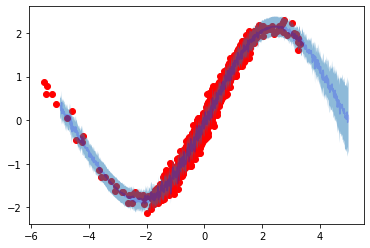

 70%|███████   | 35002/50000 [1:20:24<40:49,  6.12it/s]

NEG ELBO: -673.3520210929152


 71%|███████   | 35499/50000 [1:21:32<33:10,  7.29it/s]

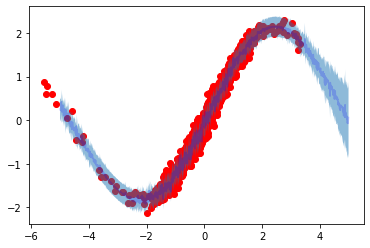

 71%|███████   | 35502/50000 [1:21:33<39:49,  6.07it/s]

NEG ELBO: -673.3766621502948


 72%|███████▏  | 35999/50000 [1:22:41<32:08,  7.26it/s]

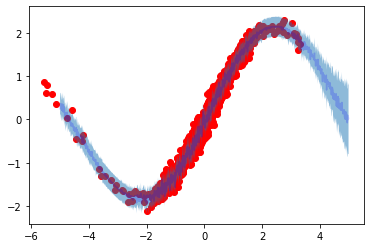

 72%|███████▏  | 36002/50000 [1:22:41<38:23,  6.08it/s]

NEG ELBO: -673.3934815771687


 73%|███████▎  | 36499/50000 [1:23:50<30:54,  7.28it/s]

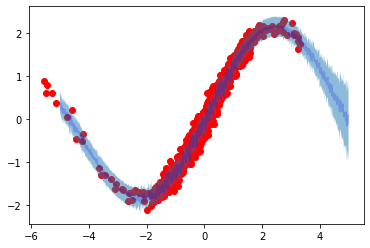

 73%|███████▎  | 36502/50000 [1:23:50<37:18,  6.03it/s]

NEG ELBO: -673.4051378341229


 74%|███████▍  | 36999/50000 [1:24:59<29:43,  7.29it/s]

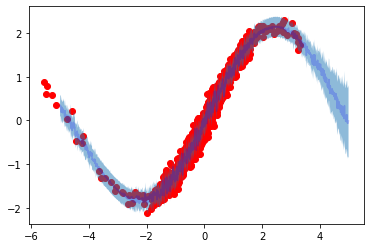

 74%|███████▍  | 37002/50000 [1:24:59<35:39,  6.08it/s]

NEG ELBO: -673.4114058229404


 75%|███████▍  | 37499/50000 [1:26:08<28:38,  7.28it/s]

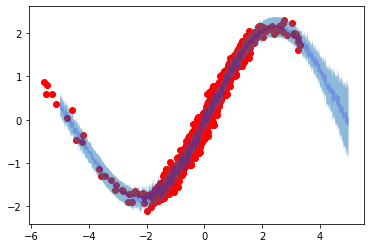

 75%|███████▌  | 37502/50000 [1:26:08<34:04,  6.11it/s]

NEG ELBO: -673.416036928818


 76%|███████▌  | 37999/50000 [1:27:16<27:26,  7.29it/s]

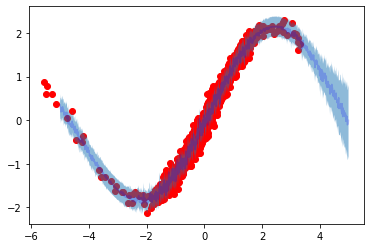

 76%|███████▌  | 38002/50000 [1:27:17<32:46,  6.10it/s]

NEG ELBO: -673.4194209678045


 77%|███████▋  | 38499/50000 [1:28:25<26:20,  7.28it/s]

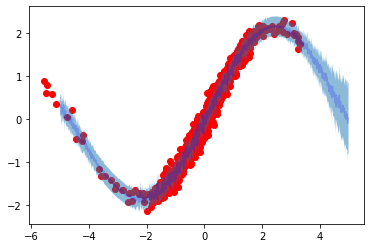

 77%|███████▋  | 38502/50000 [1:28:26<31:11,  6.14it/s]

NEG ELBO: -673.4195036237917


 78%|███████▊  | 38999/50000 [1:29:34<25:12,  7.27it/s]

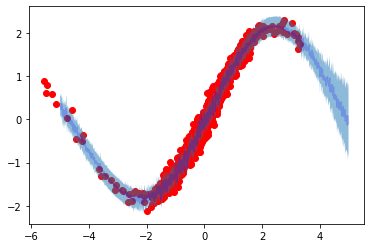

 78%|███████▊  | 39002/50000 [1:29:35<30:04,  6.09it/s]

NEG ELBO: -673.4209170610995


 79%|███████▉  | 39499/50000 [1:30:43<24:02,  7.28it/s]

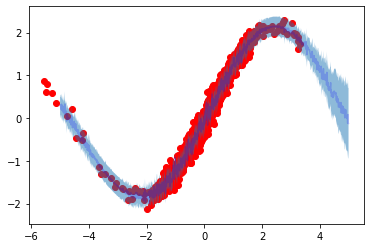

 79%|███████▉  | 39502/50000 [1:30:44<28:44,  6.09it/s]

NEG ELBO: -673.4205324307893


 80%|███████▉  | 39999/50000 [1:31:52<22:56,  7.27it/s]

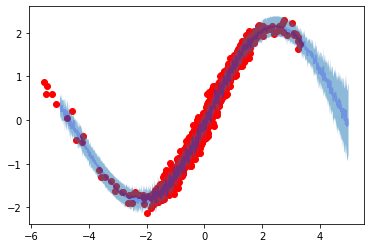

 80%|████████  | 40002/50000 [1:31:53<27:23,  6.08it/s]

NEG ELBO: -673.4211726931046


 81%|████████  | 40499/50000 [1:33:01<21:48,  7.26it/s]

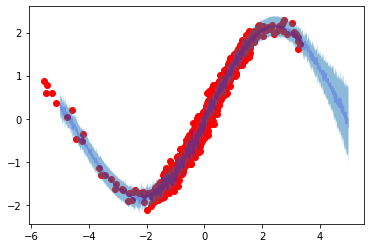

 81%|████████  | 40502/50000 [1:33:02<25:49,  6.13it/s]

NEG ELBO: -673.4218326136595


 82%|████████▏ | 40999/50000 [1:34:10<20:39,  7.26it/s]

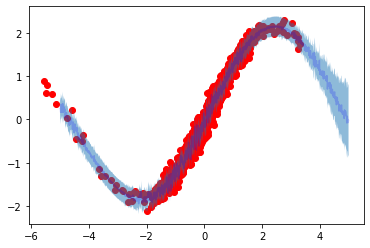

 82%|████████▏ | 41002/50000 [1:34:10<24:32,  6.11it/s]

NEG ELBO: -673.4222278106014


 83%|████████▎ | 41499/50000 [1:35:19<19:28,  7.28it/s]

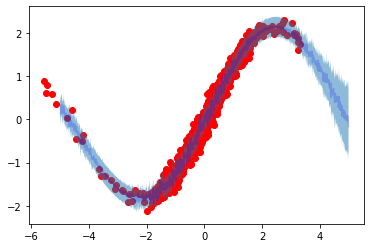

 83%|████████▎ | 41502/50000 [1:35:19<23:14,  6.09it/s]

NEG ELBO: -673.4224732996837


 84%|████████▍ | 41999/50000 [1:36:28<18:17,  7.29it/s]

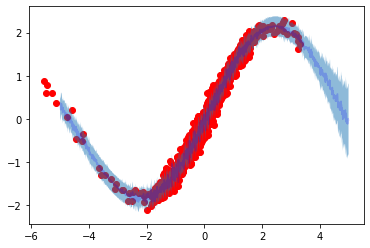

 84%|████████▍ | 42002/50000 [1:36:28<21:48,  6.11it/s]

NEG ELBO: -673.4224299823813


 85%|████████▍ | 42499/50000 [1:37:37<17:11,  7.27it/s]

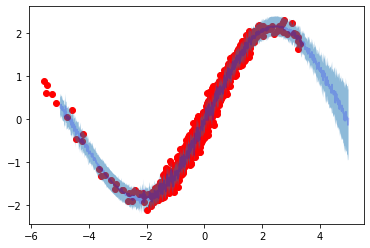

 85%|████████▌ | 42502/50000 [1:37:37<20:41,  6.04it/s]

NEG ELBO: -673.422857044113


 86%|████████▌ | 42999/50000 [1:38:45<16:01,  7.28it/s]

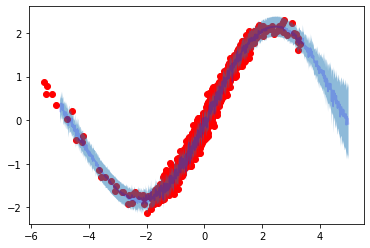

 86%|████████▌ | 43002/50000 [1:38:46<19:09,  6.09it/s]

NEG ELBO: -673.4229785962045


 87%|████████▋ | 43499/50000 [1:39:54<14:52,  7.28it/s]

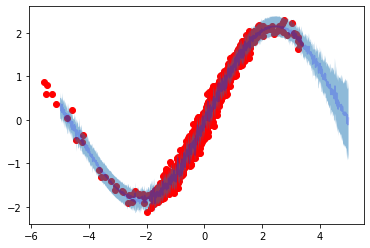

 87%|████████▋ | 43502/50000 [1:39:55<17:47,  6.09it/s]

NEG ELBO: -673.4229840003502


 88%|████████▊ | 43999/50000 [1:41:03<13:44,  7.28it/s]

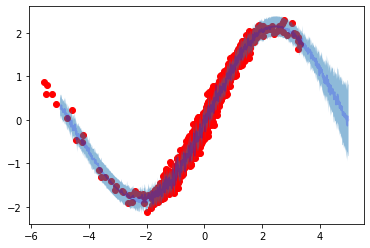

 88%|████████▊ | 44002/50000 [1:41:04<16:23,  6.10it/s]

NEG ELBO: -673.4230140304975


 89%|████████▉ | 44499/50000 [1:42:12<12:36,  7.28it/s]

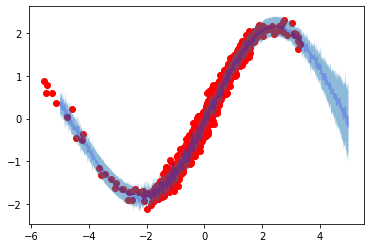

 89%|████████▉ | 44502/50000 [1:42:13<15:05,  6.07it/s]

NEG ELBO: -673.4231374513059


 90%|████████▉ | 44999/50000 [1:43:21<11:28,  7.26it/s]

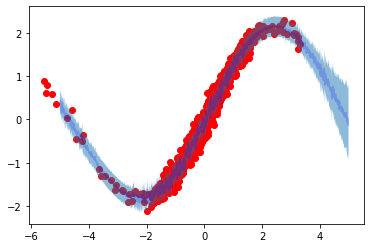

 90%|█████████ | 45002/50000 [1:43:22<13:35,  6.13it/s]

NEG ELBO: -673.4232138442302


 91%|█████████ | 45499/50000 [1:44:30<10:17,  7.28it/s]

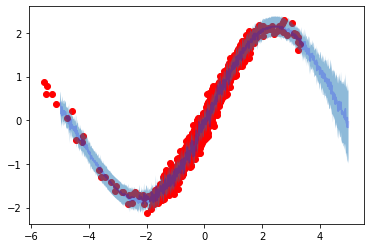

 91%|█████████ | 45502/50000 [1:44:31<12:18,  6.09it/s]

NEG ELBO: -673.4217695327677


 92%|█████████▏| 45999/50000 [1:45:39<09:10,  7.26it/s]

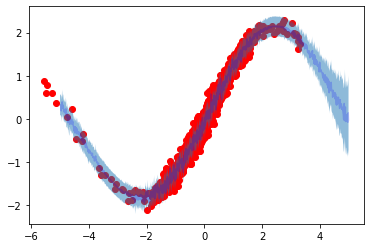

 92%|█████████▏| 46002/50000 [1:45:39<10:54,  6.11it/s]

NEG ELBO: -673.4233822094241


 93%|█████████▎| 46499/50000 [1:46:48<08:00,  7.29it/s]

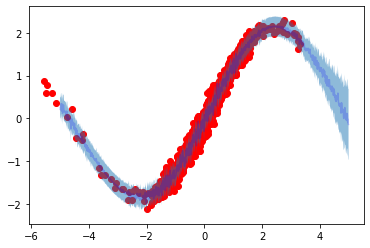

 93%|█████████▎| 46502/50000 [1:46:48<09:32,  6.10it/s]

NEG ELBO: -673.4231018744626


 94%|█████████▍| 46999/50000 [1:47:57<06:51,  7.28it/s]

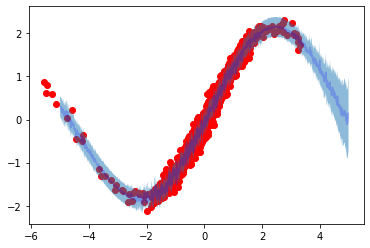

 94%|█████████▍| 47002/50000 [1:47:57<08:13,  6.08it/s]

NEG ELBO: -673.4229935473917


 95%|█████████▍| 47499/50000 [1:49:06<05:43,  7.29it/s]

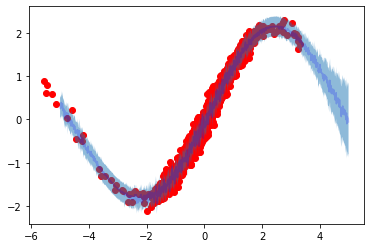

 95%|█████████▌| 47502/50000 [1:49:06<06:49,  6.10it/s]

NEG ELBO: -673.422815258275


 96%|█████████▌| 47999/50000 [1:50:14<04:34,  7.29it/s]

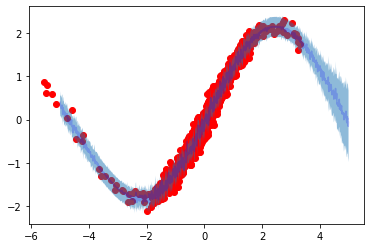

 96%|█████████▌| 48002/50000 [1:50:15<05:27,  6.10it/s]

NEG ELBO: -673.423088086789


 97%|█████████▋| 48499/50000 [1:51:23<03:26,  7.28it/s]

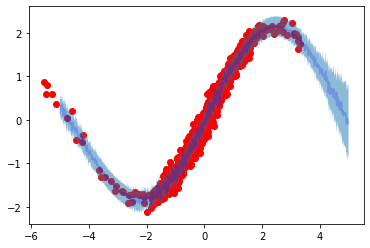

 97%|█████████▋| 48502/50000 [1:51:24<04:05,  6.09it/s]

NEG ELBO: -673.4226560751365


 98%|█████████▊| 48999/50000 [1:52:32<02:17,  7.28it/s]

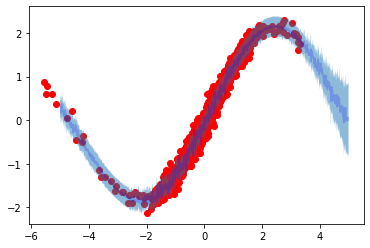

 98%|█████████▊| 49002/50000 [1:52:33<02:44,  6.07it/s]

NEG ELBO: -673.4229044504891


 99%|█████████▉| 49499/50000 [1:53:41<01:08,  7.28it/s]

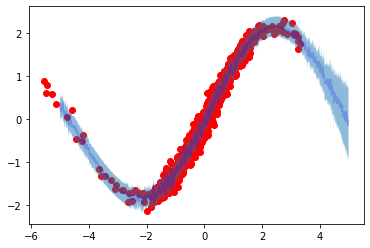

 99%|█████████▉| 49502/50000 [1:53:42<01:21,  6.13it/s]

NEG ELBO: -673.4228524402349


100%|█████████▉| 49999/50000 [1:54:50<00:00,  7.29it/s]

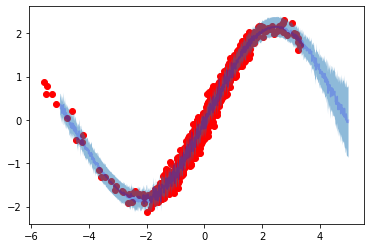

100%|██████████| 50000/50000 [1:54:51<00:00,  7.26it/s]

NEG ELBO: -673.4228331085171


In [8]:
from tqdm import trange
import matplotlib.pyplot as plt


epochs = int(50000)
with trange(1, epochs + 1) as pbar:
    for epoch in pbar:
        optimisation_step()
        if epoch % 500 == 0:
            obs_new = np.linspace(-5, 5, 1000)[:, None]
            latent_new = np.random.randn(1000, 1)
            full_new =  np.concatenate([obs_new, latent_new], axis=1)
            pred_y_mean, pred_y_var = model_bayes.predict_y(
                full_new
            )
            plt.scatter(X[:, 0], Y[:, 0], c='r')
            plt.plot(obs_new, pred_y_mean, c='b', alpha=0.2)
            # plt.scatter(inducing_in, np.zeros(100) )
            plt.fill_between(obs_new[:, 0], (pred_y_mean + 2 * np.sqrt(pred_y_var))[:, 0], (pred_y_mean - 2 * np.sqrt(pred_y_var))[:,0], alpha=0.5)
            plt.show()
            plt.close()
            print(f"NEG ELBO: {- model_bayes.elbo()}")